
# **SPOTIFY SKIP PREDICTION**

team 9: Varshitha, Winnie, Claudia 

## 1. Data loading & Importing GPU library

In [ ]:
# We need Aicrowd cli to interact with their datasets
!pip install -U aicrowd-cli

In [ ]:
import os

# Get the Aicrowd api key 
AICROWD_API_KEY = '4cb715cabb3bfc2260f966ac90df4dae'

# Downloading the tar file from aicrowd to colab notebook
!aicrowd login --api-key $AICROWD_API_KEY
!aicrowd dataset download --challenge spotify-sequential-skip-prediction-challenge '*Training_Set_And_Track_Features_Mini*'

API Key valid
Gitlab oauth token invalid or absent.
It is highly recommended to simply run `aicrowd login` without passing the API Key.
Saved details successfully!
16772e7f-7871-4d42-a44f-5f399f40fd94_training_set_track_features_mini.tar.gz: 100% 18.1M/18.1M [00:00<00:00, 29.6MB/s]


In [ ]:
# List of files present in the challenge dataset
!aicrowd dataset list -c spotify-sequential-skip-prediction-challenge 

                          Datasets for challenge #204                           
┌───┬──────────────────────────────┬───────────────────────────────┬───────────┐
│ # │ Title                        │ Description                   │      Size │
├───┼──────────────────────────────┼───────────────────────────────┼───────────┤
│ 0 │ Dataset Description          │ Description of fields for     │ 176.25 KB │
│   │                              │ dataset tables                │           │
│ 1 │ Sample_Submissions.tar.gz    │ Sample Submission             │       86M │
│ 2 │ Terms and Conditions         │ Terms and Conditions          │       61K │
│ 3 │ Test_Set.tar.gz              │ Test Set                      │       14G │
│ 4 │ Track_Features.tar.gz        │ Track Features                │      1.2G │
│ 5 │ Training_Set_And_Track_Feat… │ Minimally sized version of    │  18.06 MB │
│   │                              │ training set and track        │           │
│   │                       

In [ ]:
# Files in the tar file are put into the data folder
!tar -xvzf /content/16772e7f-7871-4d42-a44f-5f399f40fd94_training_set_track_features_mini.tar.gz

data/
data/track_features/
data/training_set/
data/training_set/._log_mini.csv
data/training_set/log_mini.csv
data/track_features/._tf_mini.csv
data/track_features/tf_mini.csv


$$$$ Importing SVM GPU Library ThunderSVM



In [ ]:
!git clone https://github.com/Xtra-Computing/thundersvm.git
!cd thundersvm && mkdir build && cd build && cmake .. && make -j
!python /content/thundersvm/python/setup.py install

In [ ]:
from importlib.machinery import SourceFileLoader
thundersvm = SourceFileLoader("thundersvm", "/content/thundersvm/python/thundersvm/thundersvm.py").load_module()
from thundersvm import SVC

## 2. Exploring the data

#### Statistical description of Data 
---

In [ ]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# computing the statistic desription of our 2 datasets
# include describe(), number of null values, distinct values, and if there are duplicates

def getDfSummary(input_data):
    output_data = input_data.describe().T
    del output_data['count']
    output_data.insert(0, 'number_nan', input_data.isnull().sum())
    output_data.insert(1, 'number_distinct', input_data.nunique(dropna = True))
    output_data.insert(2, 'duplicate', input_data.duplicated().any())

    return output_data

>> user interaction session data

In [ ]:
session_df = pd.read_csv("/content/data/training_set/log_mini.csv")
print(session_df.shape)
session_df.head()

(167880, 21)


,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [ ]:
session_df_summary = getDfSummary(session_df)
session_df_summary

,number_nan,number_distinct,duplicate,mean,std,min,25%,50%,75%,max
session_position,0,20,False,9.325911,5.457638,1.0,5.0,9.0,14.0,20.0
session_length,0,11,False,17.651823,3.422025,10.0,15.0,20.0,20.0,20.0
context_switch,0,2,False,0.040904,0.198069,0.0,0.0,0.0,0.0,1.0
no_pause_before_play,0,2,False,0.767602,0.422363,0.0,1.0,1.0,1.0,1.0
short_pause_before_play,0,2,False,0.146635,0.353742,0.0,0.0,0.0,0.0,1.0
long_pause_before_play,0,2,False,0.172832,0.378103,0.0,0.0,0.0,0.0,1.0
hist_user_behavior_n_seekfwd,0,25,False,0.038909,0.367295,0.0,0.0,0.0,0.0,60.0
hist_user_behavior_n_seekback,0,30,False,0.046259,0.606558,0.0,0.0,0.0,0.0,151.0
hour_of_day,0,24,False,14.193084,5.996243,0.0,11.0,15.0,19.0,23.0


In [ ]:
# looking at the unique values in some categorical columns
print(session_df['context_type'].unique())
print(session_df['hist_user_behavior_reason_start'].unique())
print(session_df['hist_user_behavior_reason_end'].unique())

['editorial_playlist' 'user_collection' 'radio' 'personalized_playlist'
 'catalog' 'charts']
['trackdone' 'fwdbtn' 'backbtn' 'clickrow' 'appload' 'playbtn' 'remote'
 'trackerror' 'endplay']
['trackdone' 'fwdbtn' 'backbtn' 'endplay' 'logout' 'remote' 'clickrow']


>>

>> track features data

In [ ]:
track_df = pd.read_csv("/content/data/track_features/tf_mini.csv")
print(track_df.shape)
track_df.head()

(50704, 30)


,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [ ]:
track_df_summary = getDfSummary(session_df)
track_df_summary

,number_nan,number_distinct,duplicate,mean,std,min,25%,50%,75%,max
session_position,0,20,False,9.325911,5.457638,1.0,5.0,9.0,14.0,20.0
session_length,0,11,False,17.651823,3.422025,10.0,15.0,20.0,20.0,20.0
context_switch,0,2,False,0.040904,0.198069,0.0,0.0,0.0,0.0,1.0
no_pause_before_play,0,2,False,0.767602,0.422363,0.0,1.0,1.0,1.0,1.0
short_pause_before_play,0,2,False,0.146635,0.353742,0.0,0.0,0.0,0.0,1.0
long_pause_before_play,0,2,False,0.172832,0.378103,0.0,0.0,0.0,0.0,1.0
hist_user_behavior_n_seekfwd,0,25,False,0.038909,0.367295,0.0,0.0,0.0,0.0,60.0
hist_user_behavior_n_seekback,0,30,False,0.046259,0.606558,0.0,0.0,0.0,0.0,151.0
hour_of_day,0,24,False,14.193084,5.996243,0.0,11.0,15.0,19.0,23.0


>> **Q: Are there any Tracks that are in session but not in tracks?**

In [ ]:
# answer
tracks_in_session = session_df['track_id_clean'].unique()
tracks_in_session.sort()
print('number of unique songs in session data:', len(tracks_in_session))

total_tracks_info = track_df['track_id'].unique()
total_tracks_info.sort()
print('number of unique songs in track feature data:', len(total_tracks_info))
print('all songs in the session are included in tracks:', set(tracks_in_session == total_tracks_info))

number of unique songs in session data: 50704
number of unique songs in track feature data: 50704
all songs in the session are included in tracks: {True}


**Conclusion:**

1. By taking a look at null/missing values in the mini-dataset, there seems to be no null values. And there is no duplicated information(rows).
2. All the tracks in sessions have track information in track features dataset.
3. Tracks have information about songs released from 1950 to 2018.



>> 

#### EDA before Data processing
---

**Q. Are there any features that are highly correlated?**

In [ ]:
# Gives only the most highly correlated features (>0.75 or <-0.75)
# between 2 highly correlated pairs, we will be removing one of them
def high_corr_pairs(df):
  corr_plot = df.corr()
  all_pairs = set()
  for col in corr_plot.columns:
    for row in corr_plot.columns:
      if (corr_plot[row][col]>0.75 or corr_plot[row][col]<-0.75) and (col!=row) and (col,row) not in all_pairs:
        print(row+", "+col+" = "+str(corr_plot[row][col]))
        all_pairs.add((row,col))

In [ ]:
high_corr_pairs(session_df)

skip_2, skip_1 = 0.8247510432485565
skip_3, skip_2 = 0.7621408851395522
not_skipped, skip_3 = -0.959224606856534
short_pause_before_play, no_pause_before_play = -0.7533594244390093
long_pause_before_play, no_pause_before_play = -0.8307427725730488
long_pause_before_play, short_pause_before_play = 0.90685041063389


In [ ]:
high_corr_pairs(track_df)

organism, acousticness = 0.7880050285984289
bounciness, beat_strength = 0.9654493943147716
danceability, beat_strength = 0.8753882375092104
dyn_range_mean, beat_strength = 0.890019527827767
danceability, bounciness = 0.8617317567556597
dyn_range_mean, bounciness = 0.9641798051036192
dyn_range_mean, danceability = 0.7971851660148063
organism, mechanism = -0.8673249052751622
acoustic_vector_5, acoustic_vector_3 = -0.7802582778882976


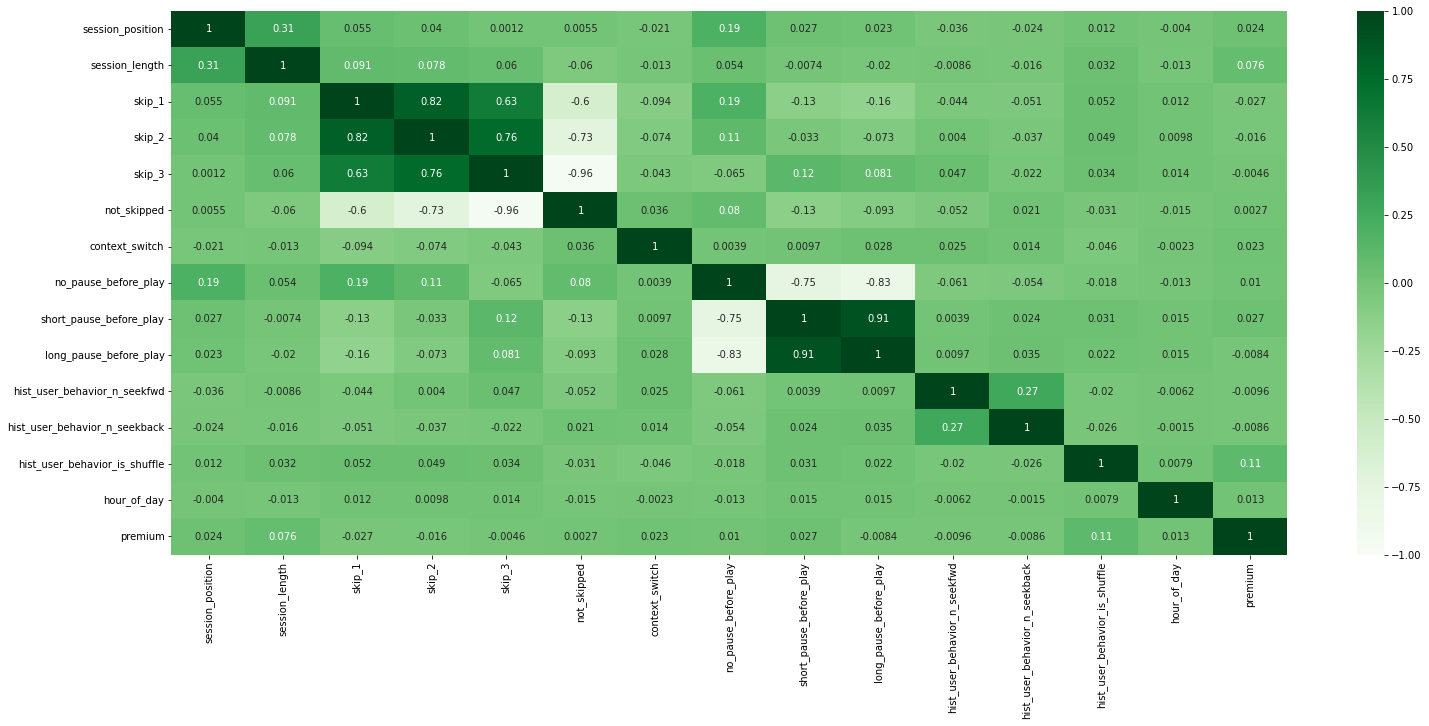

In [ ]:
#plotting correlations
import matplotlib.pyplot as plt
import seaborn as sns

# user interaction sessions
plt.figure(figsize=(25, 10))
sns.heatmap(session_df.corr(), vmin=-1, vmax=1, annot=True, cmap="Greens")

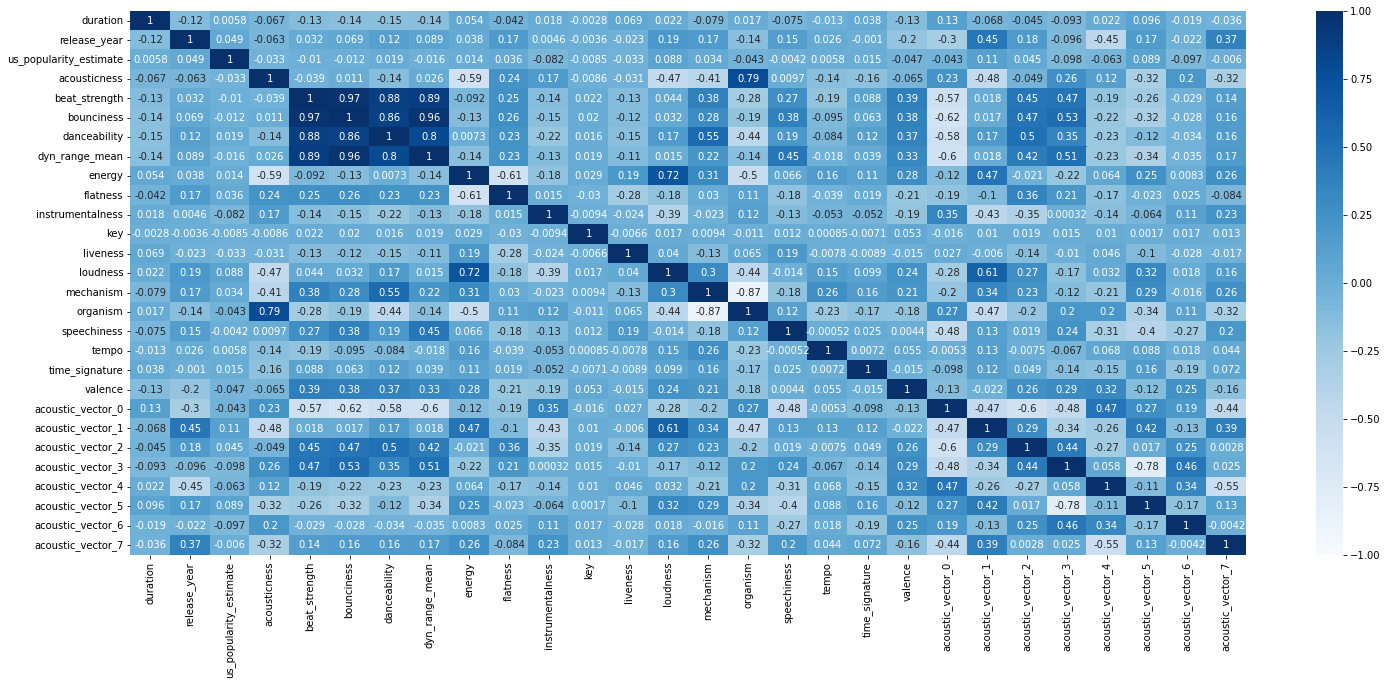

In [ ]:
# audio features
plt.figure(figsize=(25, 10))
sns.heatmap(track_df.corr(), vmin=-1, vmax=1, annot=True, cmap="Blues")

In [ ]:
# Unique combinations of skip columns and their sizes
session_df.groupby(['skip_1','skip_2','skip_3','not_skipped']).size().reset_index()

,skip_1,skip_2,skip_3,not_skipped,0
0,False,False,False,False,3145
1,False,False,False,True,55884
2,False,False,True,False,22027
3,False,True,False,False,1
4,False,True,True,False,16061
5,True,True,True,False,70762


In [ ]:
# Unique combinations of pause columns and their sizes
session_df.groupby(['no_pause_before_play','short_pause_before_play','long_pause_before_play']).size().reset_index()

,no_pause_before_play,short_pause_before_play,long_pause_before_play,0
0,0,0,0,10000
1,0,0,1,4398
2,0,1,1,24617
3,1,0,0,128865


**Conclusion:**
1. All the skips columns are correlated in session dataframe and it makes sense because each skip is an indicator of when they skipped. So if one of them is 1, the others should be 0. It also makes sense that the columns regarding the pauses before playing the track be mutually exclusive for the same reason. Because each one is dependent on each other.

2. There seems to be high correlation within all pairs of 'beat_strength', 'bounciness', 'danceability' and 'dyn_range_mean'in the case of track features dataset. 

#### Data pre-processing
---

1. Data sampling - Since the main dataset is huge, we will be using the mini-dataset which was created by Spotify itself.
2. Data cleaning - The data seems to be mostly clean with no null or missing values.

3. **Data integration** - We need to integrate the session dataframe with its respective tracks in order to train the model. There are few things to consider: 
- Make sure the order of the tracks do not get mixed up during merging. (No shuffling)


In [ ]:
# Integrating datasets
df = session_df.merge(track_df, how='left', left_on="track_id_clean", right_on="track_id")
print('Dataframe shape:', df.shape)
print('Are there any missing values in the dataframe:', df.isnull().any().any())
df.head()

Dataframe shape: (167880, 51)
Are there any missing values in the dataframe: False


,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,4,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,4,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,4,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,4,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315


4. **Feature Selection**
 - remove any redundant information like 'track_id_clean' because after integrating dataset, we already have a column 'track_id' in dataset.
 - remove features that are highly correlated.



>> Creating Customer Target Variable - 'skipped'

In [ ]:
# add custom variable 
df['skipped'] = df['skip_2'] # True - skipped, False - not skipped
df['skipped'] = np.where((df['skip_1'] | df['skip_2'] | df['skip_3'] | df['not_skipped']) == False, True, df['skip_2']) # Case of song not being played at all, mark as skipped.

In [ ]:
df.groupby(['skip_1','skip_2','skip_3','not_skipped', 'skipped']).size().reset_index()

,skip_1,skip_2,skip_3,not_skipped,skipped,0
0,False,False,False,False,True,3145
1,False,False,False,True,False,55884
2,False,False,True,False,False,22027
3,False,True,False,False,True,1
4,False,True,True,False,True,16061
5,True,True,True,False,True,70762


1. As it can be seen above, a custom target variable 'skipped' was created with 'skip_2' values. "skip_2" conveys whether the song was skipped before 1/3rd of the song was played or not. But there is also a combination in row 0 in above table where everything is false which means the song wasn't even played. We are assuming it to be skipped and changing only those to True.
2. We also can see that this creation of target variable creates balanced classes.
3. All other columns are dropped.

In [ ]:
# Dropping redundant information
df = df.drop(columns=['skip_1','skip_2','skip_3','not_skipped','track_id_clean','date'])
df.shape

(167880, 46)

>>

>> One-Hot Encoding

In [ ]:
# one hot encoding all the categorical elements
for col in df.columns:
  cols = []
  if (df[col].dtypes == object or df[col].dtypes == bool) and (col not in ['session_id','track_id']):
    cols.append(col) # All categorical and boolean columns
  df = pd.get_dummies(df,columns = cols, drop_first = True) # Get one hot encoding and drop the previous columns
print(df.shape)

(167880, 62)


>>

Feature selection by Decision tree - Decision tree here selects features based on entropy which means we intrinsically get the feature importances of the columns.

In [ ]:
# Decision Tree and Feature importance 
from sklearn.tree import DecisionTreeClassifier

num_data = df
num_data = num_data.drop('session_id', axis = 1)
num_data = num_data.drop('track_id', axis = 1)

dt = DecisionTreeClassifier(criterion="entropy")
df_pred = num_data.drop(['skipped_True'], axis=1)
df_target = num_data['skipped_True'] 

dt = dt.fit(df_pred, df_target)

Text(0.5, 1.0, 'Feature Importances')

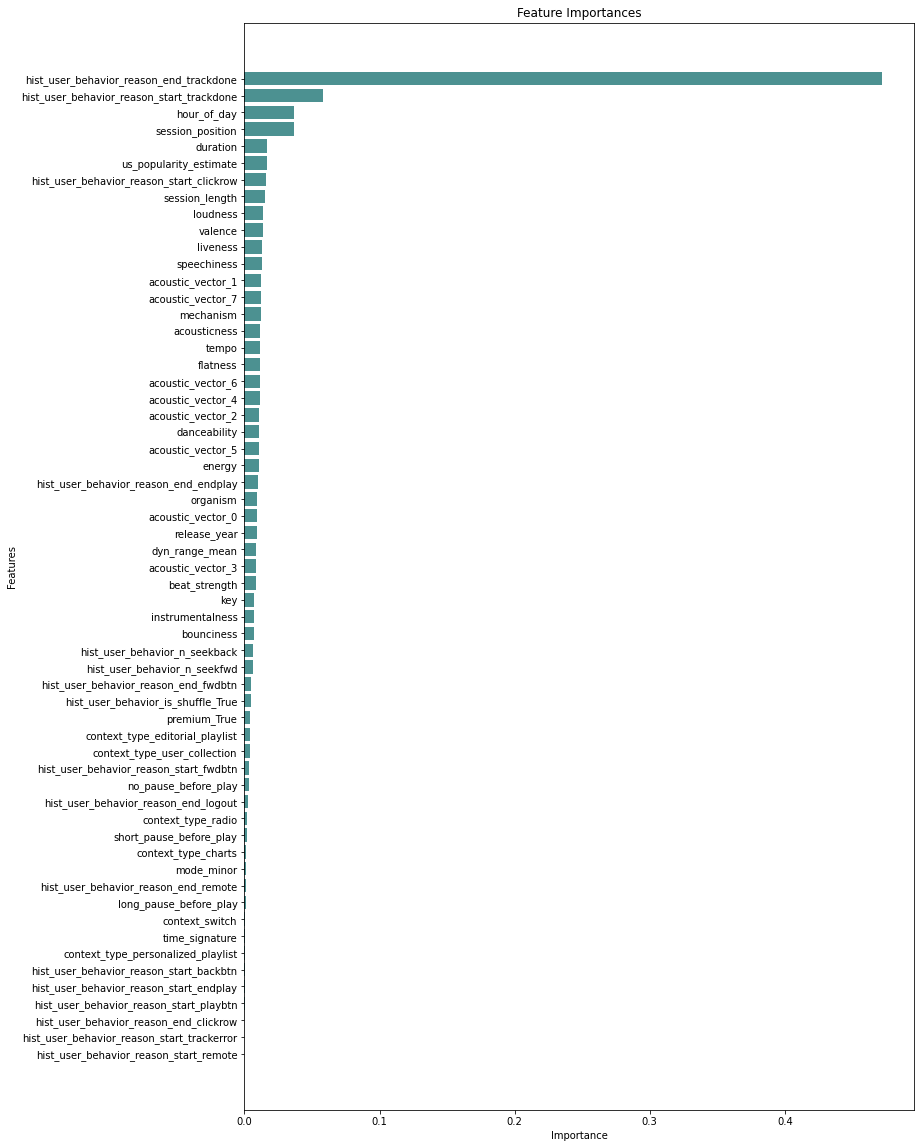

In [ ]:
# plot importances
train_importance = dt.feature_importances_
pred_var = list(df_pred.columns)
importance = pd.DataFrame({"Features":pred_var,"Importance":train_importance}).sort_values(by='Importance')

plt.figure(figsize=(12,20))
plt.barh(importance['Features'], importance['Importance'], color="#4c9191")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Feature Importances")

**Conclusion:**
1. Surprisingly, most of the top 5 features seem to be more about the user interaction behavior and session instead of track features.
2. The top most important feature is 'hist_user_behavior_reason_end_trackdone' talks about why the track is done playing. **The reason hist_user_behavior_reason_end_trackdone is the highest correlated is because there is a direct correlation of it with skipped variable. As in, if the track is done, it would mean the user didn't skip.** These variables would not be available during actual predictions. Therefore, all history_user_behaviour_end variables are removed.

In [ ]:
# removing the hist_user_behavior_reason_end variables
user_behavior_end_features = []
for new_col_name in num_data.columns:
  if new_col_name.startswith('hist_user_behavior_reason_end'):
    user_behavior_end_features.append(new_col_name)
num_data = num_data.drop(user_behavior_end_features, axis = 1)

>> 

## 3. Model Selection and Feature selection

####kFold Cross Validation for C hyperparameters: Logistic Regression and SVM

In [ ]:
# using the first 5000 rows only since we have very limited RAM
cv_data = num_data.iloc[:5000]

In [ ]:
# Dependencies 
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# using kFold to find the best value for hyperparameter c(regularization strength)
def cv_kFold(dataset, cs, model):
  X = dataset.drop(['skipped_True'], axis=1).values
  y = dataset['skipped_True'].values

  # initialize dictionary
  accuracy = {} 
  for c in cs: 
    accuracy[c] = []

  kf = KFold(n_splits=10, random_state=None)
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for c in cs:
      if model == "Logistic":
        logr = LogisticRegression(max_iter=3000, C=c) 
        logr.fit(X_train, y_train)
        logr_pred = logr.predict(X_test)
        AUC_c_k = metrics.accuracy_score(y_test, logr_pred)
      elif model == "SVM":
        svm = SVC(kernel='linear', C=c)
        svm.fit(X_train, y_train)
        svm_pred = svm.predict(X_test)
        AUC_c_k = metrics.accuracy_score(y_test, svm_pred)
      accuracy[c].append(AUC_c_k)
  return accuracy

In [ ]:
# sequence of C values
cs = [0.001, 0.01, 0.1, 0.5, 1, 2, 4, 10, 20, 40, 100]

# generate accuracy for each C value
logr_aucs = cv_kFold(cv_data, cs, "Logistic")
svm_aucs = cv_kFold(cv_data, cs, "SVM")

In [ ]:
from scipy.stats import sem

means = []
stderrs = []
model_aucs = {"Logistic" : logr_aucs, "SVM" : svm_aucs}
for key in model_aucs.keys():
  print(key)
  aucs = model_aucs[key]
  for key in aucs.keys():
    means.append(np.mean(aucs[key]))
    stderrs.append(sem(aucs[key]))
    print('c:', key, ', mean:', np.mean(aucs[key]), ', standard error:', sem(aucs[key]))

Logistic
c: 0.001 , mean: 0.7182 , standard error: 0.010143196953842724
c: 0.01 , mean: 0.764 , standard error: 0.005617433182117577
c: 0.1 , mean: 0.7690000000000001 , standard error: 0.007019021774198071
c: 0.5 , mean: 0.7682 , standard error: 0.006562181209188168
c: 1 , mean: 0.7676 , standard error: 0.006393051783859661
c: 2 , mean: 0.768 , standard error: 0.006203941399536987
c: 4 , mean: 0.7678 , standard error: 0.006898953221725426
c: 10 , mean: 0.7678 , standard error: 0.006636264009214829
c: 20 , mean: 0.7689999999999999 , standard error: 0.006104643041707413
c: 40 , mean: 0.7694000000000001 , standard error: 0.006680319353643711
c: 100 , mean: 0.7694 , standard error: 0.0060372915192898335
SVM
c: 0.001 , mean: 0.7614 , standard error: 0.004908496035786662
c: 0.01 , mean: 0.7680000000000001 , standard error: 0.006902495522957223
c: 0.1 , mean: 0.6702 , standard error: 0.00775428197120074
c: 0.5 , mean: 0.6574 , standard error: 0.007607306429421068
c: 1 , mean: 0.65460000000000

**Logistic Regression:**

We can see that c=0.1 and c=40 had the highest mean accuracy, with very similar standard error value. In the case of logistic regression, a high C value of 40 puts a lot of emphasis on the training data and has a very low regularization strength. But since we are only using a small sample of the data for cross validation, the training data here might not be too representative of the entire dataset. Therefore, it might be better to usue c=0.1 to give more weight to this complexity penalty, less to the training data, when it comes to classifying the entire dataset.

**SVM:**

In the case of Support Veector Machines, the accuracy is highest when C = 0.01. In fact, models with C values >= 0.5 do exceptionally worse, at an average of 0.65 accuracy. This suggests that when regularization is smaller and training data is weighted greater, the models overfit the training data and do not do as well.

>>

#### Testing different models on different feature selections

>> We are testing the accuracy of the models based on the feature selection. There are five different feature selections that are being done for comparison.

In [ ]:
# Different Feature selectors

"""
The following are features we want to remove from our dataset for training.
For reusability of the code and data, we will be selecting instead of dropping
the columns.
"""
"""
Features selected based on pairwise correlations in the EDA section.
When many columns seem to be highly correlated only the feature with lower
correlation is kept while the others are removed. 
"""
list_of_features_1 = ['short_pause_before_play', 'long_pause_before_play', 'acousticness', 'organism', 'bounciness', 'beat_strength', 'dyn_range_mean'] 
"""
The top features from the decision tree feature importances are selected.
"""
# Sorting list based on feature importance in ascending order
sorted_asc_col = [x for _,x in sorted(zip(dt.feature_importances_,num_data.drop(columns = ['skipped_True']).columns))] 
# Bottom 50% important features
list_of_features_2 = sorted_asc_col[:len(sorted_asc_col)//2]
# Bottom 30% important features
list_of_features_3 = sorted_asc_col[:int(len(sorted_asc_col) * 0.3)]
# User behaviour features
list_of_features_4 = []
for col_name in session_df.columns:
  for new_col_name in num_data.columns:
    if new_col_name.startswith(col_name):
      list_of_features_4.append(new_col_name)
# Track features
list_of_features_5 = []
for col_name in track_df.columns:
  for new_col_name in num_data.columns:
    if new_col_name.startswith(col_name):
      list_of_features_5.append(new_col_name)

# Adding custom_skip_var_True to list values that need to be removed from training data
list_of_features_1.append('skipped_True')
list_of_features_2.append('skipped_True')
list_of_features_3.append('skipped_True')
list_of_features_4.append('skipped_True')
list_of_features_5.append('skipped_True')

In [ ]:
# Train-Test Split
from sklearn.model_selection import train_test_split

def get_train_test_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [ ]:
# Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN
import tensorflow as tf

# Neural network - define the keras model
def construct_model(X_train, model_type = 'CNN'):
  if model_type == 'CNN':
    tf.random.set_seed(124)
    model = Sequential()
    model.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
  elif model_type == 'LogReg': # Logistic Regression
    model = LogisticRegression(C=0.1, max_iter=3000)
  elif model_type == 'SVM':
    model = SVC(kernel = 'linear', C = 0.01)
  return model

In [ ]:
# Training and Testing with different feature selections
# By default it removes no features
def train_test_model_different_config(list_of_features_to_remove = ['skipped_True'], model_type = 'CNN'):
  X_train, X_test, y_train, y_test = get_train_test_split(num_data.loc[:, ~num_data.columns.isin(list_of_features_to_remove)], num_data['skipped_True'])
  model = construct_model(X_train, model_type)
  if model_type == 'CNN':
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)
    # evaluate the keras model
    _, accuracy = model.evaluate(X_test, y_test)
  elif model_type == 'LogReg': # Logistic Regression
    model.fit(X_train, y_train)
    logr_pred_test = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, logr_pred_test)
  elif model_type == "SVM":
    model.fit(X_train, y_train)
    svm_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, svm_pred)
  print('Test Accuracy: %.2f' % (accuracy*100))
  return accuracy*100

The below code tests different feature selections and models. Therefore, it'll take a lot of time for their runtime ~ 15 - 20 mins. 

In [ ]:
# Testing different feature selections and models
list_of_features = [list_of_features_1,list_of_features_2,list_of_features_3,list_of_features_4,list_of_features_5]
list_of_names = ['Remove Pairwise Highly correlated', 'Remove Bottom 50% important', 'Remove Bottom 30% important', 'Remove User behaviour features', 'Remove Track features']

In [ ]:
result_dict = dict()
# With no feature selection
test_acc_1 = train_test_model_different_config()
test_acc_2 = train_test_model_different_config(model_type='LogReg')
test_acc_3 = train_test_model_different_config(model_type = "SVM")
result_dict['No feature selection'] = [test_acc_1,test_acc_2, test_acc_3]
# With feature selection
for i in range(len(list_of_features)):
  test_acc_1 = train_test_model_different_config(list_of_features[i])
  test_acc_2 = train_test_model_different_config(list_of_features[i],'LogReg')
  test_acc_3 = train_test_model_different_config(list_of_features[i], 'SVM')
  result_dict[list_of_names[i]] = [test_acc_1,test_acc_2, test_acc_3] 

In [ ]:
# Features removed for each set
print(list_of_features_1)
print(list_of_features_2)
print(list_of_features_3)
print(list_of_features_4)
print(list_of_features_5)

['short_pause_before_play', 'long_pause_before_play', 'acousticness', 'organism', 'bounciness', 'beat_strength', 'dyn_range_mean', 'skipped_True']
['hist_user_behavior_reason_start_remote', 'hist_user_behavior_reason_start_trackerror', 'mode_minor', 'hist_user_behavior_reason_start_playbtn', 'hist_user_behavior_reason_start_endplay', 'hist_user_behavior_reason_start_backbtn', 'time_signature', 'context_type_personalized_playlist', 'context_switch', 'long_pause_before_play', 'context_type_charts', 'short_pause_before_play', 'context_type_radio', 'no_pause_before_play', 'premium_True', 'hist_user_behavior_reason_start_fwdbtn', 'context_type_user_collection', 'context_type_editorial_playlist', 'hist_user_behavior_is_shuffle_True', 'hist_user_behavior_n_seekfwd', 'hist_user_behavior_n_seekback', 'key', 'bounciness', 'instrumentalness', 'dyn_range_mean', 'beat_strength', 'skipped_True']
['hist_user_behavior_reason_start_remote', 'hist_user_behavior_reason_start_trackerror', 'mode_minor', 'h

In [ ]:
# Visualizing the Results from different configurations
results = pd.DataFrame(data=result_dict, index=['CNN', 'Logistic Regression', 'SVM']).T
results

,CNN,Logistic Regression,SVM
No feature selection,75.911367,75.991780,64.668215
Remove Pairwise Highly correlated,76.149631,75.488444,64.864784
Remove Bottom 50% important,74.723017,75.762449,62.115797
Remove Bottom 30% important,76.075172,75.899452,63.870026
Remove User behaviour features,53.517395,53.469740,50.515249
Remove Track features,76.414698,76.033476,75.759471


>> 

####plotting the ROC-AUC curves

In [ ]:
# plotting the ROC-AUC curve
# code taken from homework 5

from sklearn.metrics import roc_auc_score, roc_curve, auc

def getAUC(truth, pred):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    return auc(fpr, tpr)

def plotAUC(truth, pred, lab, title):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title)
    plt.legend(loc="lower right")

In [ ]:
def AUC_plot(list_of_features_to_remove = ['skipped_True'], name = '', model_type = "LogReg"):
  X_train, X_test, y_train, y_test = get_train_test_split(num_data.loc[:, ~num_data.columns.isin(list_of_features_to_remove)], num_data['skipped_True'])
  model = construct_model(X_train, model_type)

  if model_type == 'LogReg': # Logistic Regression
    model.fit(X_train, y_train)
    logr_pred = model.predict_proba(X_test)[:,1]
    roc_auc = getAUC(y_test, logr_pred)
    plotAUC(y_test, logr_pred, name, 'Logistic Regression ROC-AUC Curve')

  elif model_type == 'SVM':
    model.fit(X_train, y_train)
    svm_pred = model.decision_function(X_test)
    roc_auc = roc_curve(y_test, svm_pred)[:-1]
    plotAUC(y_test, svm_pred, name, "SVM ROC-AUC Curve")
  return roc_auc

<Figure size 1800x1296 with 0 Axes>

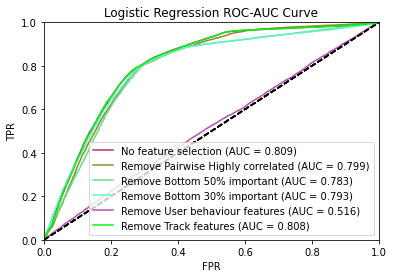

<Figure size 1800x1296 with 0 Axes>

In [ ]:
# Logistic Regression

# With no feature selection
test_auc_1 = AUC_plot(name ='No feature selection', model_type='LogReg')

# With feature selection for LogReg
for i in range(len(list_of_features)):
  test_auc_1 = AUC_plot(list_of_features[i], list_of_names[i], 'LogReg')

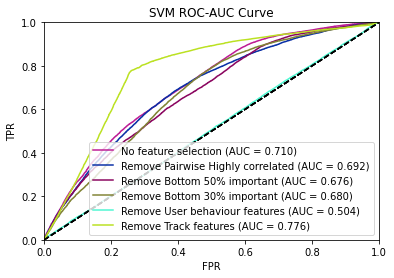

In [ ]:
#SVM 

# With no feature selection
test_auc_2 = AUC_plot(name = "No feature selection", model_type = "SVM")

# With feature selection for SVM
for i in range(len(list_of_features)):
  test_auc_2 = AUC_plot(list_of_features[i], list_of_names[i], 'SVM')

For logistic regression and SVM, the feature selection that resulted in the highest AUC score is with removing only the track features. 

>>

#### RNN: Proposed method

>> **Restructuring of data -** In order to give the input to the RNN, the data is restructured in such a way that one row in the input would contain track features of the entire session (20 tracks). The output would be the skipped variable for all 20 tracks. Since, some sessions do not have 20 tracks, they are padded with zeros.

In [ ]:
def restructure_data(new_df, list_of_features_to_remove):
  X = []
  y = []
  curr_row = 0
  while curr_row < new_df.shape[0]: # Iterate over the rows
    X_temp = []
    y_temp = []
    sess_len = new_df.iloc[curr_row]['session_length'] # Session length
    sess_end_row = curr_row + sess_len - 1
    # Checking if it has same session id
    if new_df.iloc[curr_row]['session_id'] == new_df.iloc[sess_end_row]['session_id']:
      for i in range(curr_row,sess_end_row+1):
        X_temp.append(list(new_df.loc[i, ~new_df.columns.isin(['session_id','track_id','skipped_True']+ list_of_features_to_remove)]))

      y_temp = list(new_df.iloc[curr_row:sess_end_row + 1]['skipped_True'])

      if sess_len!= 20: # Padding other values with 0
        for i in range(0,20-sess_len):
          X_temp.append([0]*len(X_temp[0]))
          y_temp.append(0)
      X.append(X_temp)
      y.append(y_temp)
    curr_row += sess_len
  
  # Train test split
  X_train, X_test, y_train, y_test = get_train_test_split(np.array(X), np.array(y))
  return X_train, X_test, y_train, y_test


In [ ]:
def construct_model(X_train):
  tf.random.set_seed(1234)
  model = Sequential()
  model.add(Dense(20, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
  model.add(SimpleRNN(units=20, return_sequences=True, activation=tf.nn.relu))
  model.add(Dense(12, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
def train_RNN(df, list_of_features_to_remove):
  X_train, X_test, y_train, y_test = restructure_data(df,list_of_features_to_remove)
  model = construct_model(X_train)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)
  # evaluate the keras model
  _, accuracy = model.evaluate(X_test, y_test)
  # Returns test accuracy
  return accuracy

In [ ]:
# Need the data with session id to combine them into one row
new_df = df
# Removing the history end variables as explained previously
list_of_hist_end = ['hist_user_behavior_reason_end_clickrow',
 'hist_user_behavior_reason_end_endplay',
 'hist_user_behavior_reason_end_fwdbtn',
 'hist_user_behavior_reason_end_logout',
 'hist_user_behavior_reason_end_remote',
 'hist_user_behavior_reason_end_trackdone'] 
new_df = new_df.drop(list_of_hist_end, axis = 1)
result_dict = dict()
# With no feature selection
test_acc_1 = train_RNN(df,[])
result_dict['No feature selection'] = [test_acc_1]
# With feature selection
for i in range(len(list_of_features)):
  test_acc_1 = train_RNN(df,list_of_features[i])
  result_dict[list_of_names[i]] = [test_acc_1] 

In [ ]:
# Visualizing the Results from different configurations
results = pd.DataFrame(data=result_dict, index=['RNN']).T
results

,RNN
No feature selection,0.873275
Remove Pairwise Highly correlated,0.855175
Remove Bottom 50% important,0.830875
Remove Bottom 30% important,0.832800
Remove User behaviour features,0.836975
Remove Track features,0.888500


**Conclusion and Discussion**
1. Overall, RNN seems to be performing (test accuracy) better than any other model. It could be because each session belongs to the same user and hence keeping 20 session features as one input could predict the skipability better.
2. While trying to train the RNN, it was observed that random seed needed to be fixed to observe consistent results.
3. Overall, removing track features was giving the highest accuracy for all models. This made us come to conclusion that Spotify needs to focus more on user interaction to predict the skipability.